<a href="https://colab.research.google.com/github/intellitrend-global/google_hackathon_bq_ai/blob/main/process_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 ESG & 💲Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis



# 🔑Setup & Authentication

In [84]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


print("✅ Authentication complete!")
print("✅ Libraries installed!")

🌟 Welcome to the ESG & Financial Intelligence Platform!
🔧 Setting up environment...
✅ Authentication complete!
✅ Libraries installed!


# 🚀 Intializing Parameters

In [89]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo
# we can use an array / list if we need to process more than one company

company1 = "novartis"
company2 ="glaxosmithkline"
company3 = "pfizer"
company4 = "amgen"

DATA_FILES_PATH="gs://report_insights"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ

OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro" # or any other gemini model
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"




# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [90]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

✅ Project configured: intellitrend-project-dev
✅ BigFrames ready for action!


# 🔗Create Cloud Resource Connection

In [91]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

BigQuery error in mk operation: Already Exists: Connection
projects/573553606303/locations/us/connections/ghack_conn


# 🆔Fetch Service Account associated with the Cloud Res Connection

In [92]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

bqcx-573553606303-2s0n@gcp-sa-bigquery-condel.iam.gserviceaccount.com


# 👥Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [7]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
# time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


#✦ Create the Gemini Model

In [8]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

🤖 Creating Gemini 2.5 Pro model...
🎉 Gemini 2.5 Pro model created successfully!


# 𝄜 Create **Object Table** for PDF Reports

In [5]:
print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/{company1}/*', '{DATA_FILES_PATH}/{company2}/*', '{DATA_FILES_PATH}/{company3}/*', '{DATA_FILES_PATH}/{company4}/*']
);
"""

# Uncomment to process a single file for testing

# create_external_table_sql = f"""
# CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
# WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
# OPTIONS (
#   object_metadata = 'SIMPLE',
#   uris = ['{DATA_FILES_PATH}/{company1}/{company1}_annualreport_2020.pdf']
# );
# """

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())


except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")



📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 52 files in storage
Sample files:


                                                 uri     size
0  gs://report_insights/novartis/novartis_annualr...  4228147
1  gs://report_insights/novartis/novartis_annualr...  3767323
2  gs://report_insights/novartis/novartis_annualr...  3598595
3  gs://report_insights/novartis/novartis_annualr...  3990455
4  gs://report_insights/novartis/novartis_annualr...  3861068

[5 rows x 2 columns]


#  ֎ Extract Financial & ESG Data - **Using ML.GENERATE_TEXT**

In [49]:

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
        You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch a very detailed financial sustainability details and metrics from text, tabular and image data for each PDF.
        If the report is financial, fetch all the financial  data and metrics and skip any sustainability or ESG details.
        If the report is ESG/Impact/Sustainability/Climate, skip the financial metrics and details and focus on ESG.
        ** Ensure data for revenue, assets, net income, scope emissions.

      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%' or  uri like '%{company4}%'
);
"""
#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... ")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes novartis, glaxosmithkline, and pfizer reports...
⏳ Processing... 
✅ Successfully processed 52 files!


# 🧹 Extract **Clean** Text Response

In [50]:
print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT
  *,
  REGEXP_REPLACE(
    ARRAY_TO_STRING(
      ARRAY(
        SELECT JSON_VALUE(part, '$.text')
        FROM UNNEST(JSON_QUERY_ARRAY(
          JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
        )) AS part
      ),
      ''
    ),
    r'```(json)?|```',
    ''
  ) AS response_text
FROM `{QUALIFIED_RAW_TABLE_ID}`;
"""


try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/amgen/amgen_sustainabilityreport_2024.pdf
Text: Based on my analysis of the Amgen 2024 Sustainability Highlights Report, here is a detailed breakdown of the financial and ESG metrics.

### **Financial Metrics**

The report provides key financial fi...

File: gs://report_insights/glaxosmithkline/glaxosmithkline_sustainabilityreport_2019.pdf
Text: Based on the GSK ESG Performance Summary for 2019, here are the detailed financial and sustainability metrics.

### **Financial Performance (2019)**

The report provides the following key financial fi...

File: gs://report_insights/glaxosmithkline/glaxosmithkline_sustainabilityreport_2020.pdf
Text: Based on the GSK ESG Performance Summary 2020, here is a detailed breakdown of the company's financial and ESG sustainability details and metrics.

### **General & Financial Overview (2020)**

While t...



# 🎛️ **Using AI.GENERATE** Interactive extraction of required data OR Fetch all default questions for any given company/year and report type (Annual/Sustainability)

In [51]:
from IPython.display import display, Markdown

print(f"֎ Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, {company3}, {company4} reports...")

user_question="'Give Consolidated Statements of Cash Flows in tabular format'"
user_question=""
selected_company = "glaxosmithkline"
selected_year = "2024"
selected_report_type="annual"

if selected_report_type=="annual":
  default_questions="""
CONCAT('Answer all the below questions:',
'Read the data and fetch the below details:',
'Financial Performance',
'What is the total revenue this year?',
'What is the total assets this year?',
'What is the total net income this year?',
'How has revenue changed compared to last year?',
'What is the net profit or loss?',
'How have the earnings per share (EPS) changed?',
'Are gross margins improving or declining?',
'Are operating margins stable or volatile?',
'How has net margin shifted year over year?',
'Is cash flow from operations positive and consistent?',
'How much free cash flow is available?',
'How are working capital levels trending?',

'Balance Sheet & Liquidity',
'What is the total debt level?',
'Is the debt-to-equity ratio rising or falling?',
'Does the company have enough liquidity to cover short-term liabilities?',
'What is the current ratio and quick ratio?',
'How much cash and equivalents are available?',
'Are interest expenses sustainable?',
'How sensitive is the company to interest rate changes?',
'What is the level of contingent liabilities?',

'Business Strategy',
'What are the company’s core growth initiatives?',
'Is management investing in new markets or products?',
'How much is spent on research and development (R&D)?',
'Are acquisitions or divestitures planned?',
'Is the company expanding geographically?',
'What is the company competitive advantage?',
'Is the advantage sustainable against competitors?',
'Is digital transformation a core part of the strategy?',

'Risk Factors',
'What macroeconomic risks affect the business?',
'What industry-specific risks are highlighted?',
'What operational risks are disclosed?',
'Are supply chain risks material?',
'Are legal or regulatory risks mentioned?',
'How is foreign exchange risk managed?',
'How dependent is revenue on a few customers?',
'Are raw material price risks significant?',

'Governance & Leadership',
'Is the board majority independent?',
'How many women or minorities are on the board?',
'Is executive compensation performance-linked?',
'Does management own significant equity?',
'Are shareholder rights well protected?',
'Is succession planning disclosed?',
'Has management delivered on past promises?',
'Is the auditor independent and credible?',

'Shareholder Value',
'Is the company paying dividends?',
'Is the dividend payout sustainable?',
'Is the dividend policy clear?',
'Are share buybacks taking place?',
'Is return on equity (ROE) improving?',
'Is return on assets (ROA) stable?',
'Has shareholder equity grown consistently?',
'What is the earnings guidance for next year?'
)
"""
else:
  default_questions="""
CONCAT('Answer all the below questions:',
'Read the data and fetch the below details:',
'Investor Questions – Sustainability Reports',

'Environmental',
'What is the total Scope 1 emissions?',
'What is the total Scope 2 emissions?',
'What is the total Scope 3 emissions?',
'Are science-based targets disclosed?',
'Has the company committed to net-zero?',
'What percentage of energy is renewable?',
'Is energy efficiency improving year over year?',
'What is the total water withdrawal?',
'What is water recycled or reused?',
'Is the company exposed to water stress?',
'How much total waste is generated?',
'How much waste is recycled or diverted from landfill?',
'Are hazardous waste levels disclosed?',
'How sustainable are raw material sourcing practices?',
'Are biodiversity risks addressed?',

'Social',
'What is the total workforce size?',
'What percentage of employees are women?',
'What percentage of leadership roles are held by women?',
'What is minority representation in the workforce?',
'What is the employee turnover rate?',
'How many workplace injuries occurred?',
'What is the lost-time injury frequency rate?',
'Are labor rights respected across the supply chain?',
'Is child labor risk disclosed in supply chains?',
'Are employee training hours increasing per year?',
'Are wages above local living wage levels?',
'Is there employee engagement survey data?',
'What community development initiatives exist?',
'What philanthropic contributions were made?',
'Is there disclosure on data privacy and cybersecurity?',

'Governance (ESG-specific)',
'Is there a dedicated board ESG committee?',
'How often does the board review ESG matters?',
'Is ESG risk included in enterprise risk management?',
'Is executive compensation tied to ESG goals?',
'Are ESG targets linked to management incentives?',
'Is ESG performance externally assured?',
'Are ESG disclosures aligned with GRI or SASB?',
'Does the company report under TCFD or ISSB?',
'Is CDP reporting publicly available?',
'Are stakeholder engagement practices disclosed?',

'Risk & Opportunity',
'What are the identified physical climate risks?',
'What are the identified transition risks?',
'Is there disclosure on carbon pricing exposure?',
'How dependent is revenue on carbon-intensive activities?',
'What sustainability-linked opportunities are identified?',
'Are green products or services generating revenue?',
'Is access to sustainable finance increasing?',
'Are suppliers evaluated for ESG performance?',
'Are ESG clauses included in supplier contracts?',
'Is there disclosure on product lifecycle impacts?'
)
"""

# -------------------------------
# Build prompt
# -------------------------------
if user_question.strip():
    question_block = f"{user_question}"
else:
    question_block = f"{default_questions}"



generate_text_sql2 = f"""
 SELECT
    response_text,
    AI.GENERATE(
    (
      CONCAT({question_block}),
    response_text),
    connection_id => '{PROJECT_LOCATION}.{CLOUD_RES_CONN}',
  endpoint => '{MODEL_ENDPOINT}'
).result
FROM `{QUALIFIED_CURATED_TABLE_ID}`
WHERE (uri like '%{selected_company}%')
AND uri like '%{selected_year}%'
AND uri like '%{selected_report_type}%';
"""



#print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... ")
    # job = client.query(generate_text_sql2)
    # job.result()

    sample_df2 = bpd.read_gbq(generate_text_sql2)
    print("\n📝 \n\n\n**************************:")
    for _, row in sample_df2.iterrows():
      text=row['result']
      display(Markdown(text))

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

֎ Processing PDFs with gemini_model_25pro...
This analyzes novartis, glaxosmithkline, pfizer, amgen reports...
⏳ Processing... 

📝 


**************************:


Based on the GSK Annual Report 2024 data provided, here are the answers to your questions.

### **Financial Performance**

*   **What is the total revenue this year?**
    Total revenue (Turnover) for 2024 is **£31,376 million**.

*   **What is the total assets this year?**
    Total assets for 2024 are **£59,463 million**.

*   **What is the total net income this year?**
    Total net income (Profit Attributable to Shareholders) for 2024 is **£2,575 million**.

*   **How has revenue changed compared to last year?**
    Revenue increased from £30,328 million in 2023 to **£31,376 million** in 2024. The report notes this is a growth of **7% at Constant Exchange Rate (CER)**.

*   **What is the net profit or loss?**
    The company had a net profit of **£2,575 million** in 2024.

*   **How have the earnings per share (EPS) changed?**
    Total EPS significantly decreased from 121.6p in 2023 to **63.2p** in 2024. However, Core EPS, which excludes certain charges, increased from 155.1p in 2023 to **159.3p** in 2024 (a 10% growth at CER).

*   **Are gross margins improving or declining?**
    The provided data does not include gross profit or gross margin figures, so this cannot be determined.

*   **Are operating margins stable or volatile?**
    Operating margins are **volatile**. The Total Operating Profit margin declined significantly in 2024 (approx. 12.8%) compared to 2023 (approx. 22.2%), primarily due to a £1.8 billion charge for the Zantac settlement. The Core Operating Profit margin, however, appears more stable and is growing.

*   **How has net margin shifted year over year?**
    The net margin has **declined significantly**. It fell from approximately 16.3% in 2023 (£4,928m / £30,328m) to **approximately 8.2%** in 2024 (£2,575m / £31,376m).

*   **Is cash flow from operations positive and consistent?**
    Yes, cash flow from operations is **positive and highly consistent**. It was £7,861 million in 2024, £8,096 million in 2023, and £7,944 million in 2022.

*   **How much free cash flow is available?**
    The available free cash flow for 2024 is **£2,863 million**.

*   **How are working capital levels trending?**
    The provided data does not contain information on working capital levels.

---

### **Balance Sheet & Liquidity**

*   **What is the total debt level?**
    The Net Debt as of 2024 is **£13,095 million**. The report shows this has been decreasing from £17,197 million in 2022.

*   **Is the debt-to-equity ratio rising or falling?**
    The provided data does not include Shareholder Equity figures, so the debt-to-equity ratio cannot be calculated.

*   **Does the company have enough liquidity to cover short-term liabilities?**
    The provided data does not include current assets or current liabilities, so this cannot be determined.

*   **What is the current ratio and quick ratio?**
    The provided data does not contain the necessary components (like current assets and liabilities) to calculate the current or quick ratio.

*   **How much cash and equivalents are available?**
    The balance sheet figure for cash and equivalents is not provided. The report does state that cash generated from operations was £7,861 million.

*   **Are interest expenses sustainable?**
    The provided data does not include details on interest expenses.

*   **How sensitive is the company to interest rate changes?**
    The provided data does not mention the company's sensitivity to interest rate changes.

*   **What is the level of contingent liabilities?**
    The report does not provide a total figure for contingent liabilities, but it highlights a major realized one: a **£1.8 billion charge for the Zantac settlement** which impacted the 2024 operating profit.

---

### **Business Strategy**

*   **What are the company’s core growth initiatives?**
    Growth is primarily driven by its **Specialty Medicines portfolio**, which saw 19% CER growth in 2024.

*   **Is management investing in new markets or products?**
    Yes, the company is heavily investing in new products, as evidenced by its R&D investment of **£6,401 million** in 2024, an increase from prior years. The data does not specify investment in new markets.

*   **How much is spent on research and development (R&D)?**
    **£6,401 million** was spent on R&D in 2024.

*   **Are acquisitions or divestitures planned?**
    The provided data does not mention any planned acquisitions or divestitures.

*   **Is the company expanding geographically?**
    The provided data does not contain information on geographical expansion plans.

*   **What is the company competitive advantage?**
    The data suggests the competitive advantage lies in its strong **Specialty Medicines portfolio** and its commitment to innovation through high **R&D investment**. Its high ranking (**2nd**) in the Access to Medicine Index also indicates a competitive strength in global health.

*   **Is the advantage sustainable against competitors?**
    The continued high investment in R&D and strong performance in the Access to Medicine Index suggest an effort to sustain its advantage, but the document does not explicitly state this.

*   **Is digital transformation a core part of the strategy?**
    The provided data does not mention digital transformation.

---

### **Risk Factors**

*   **What macroeconomic risks affect the business?**
    **Foreign exchange risk** is implied, as the company reports results at both actual and Constant Exchange Rates (CER).

*   **What industry-specific risks are highlighted?**
    **Litigation risk** is a significant highlighted risk, demonstrated by the £1.8 billion charge for the Zantac settlement.

*   **What operational risks are disclosed?**
    **Environmental compliance risks** are implied by the detailed tracking and targets for GHG emissions, water usage, and waste management.

*   **Are supply chain risks material?**
    Yes, they appear to be material. The report notes that the supply chain accounts for **37%** of the company's value chain carbon footprint (Scope 3), indicating its significance and potential as a source of risk.

*   **Are legal or regulatory risks mentioned?**
    Yes, the **Zantac settlement** is a major legal issue mentioned that directly impacted financials.

*   **How is foreign exchange risk managed?**
    The provided data does not state how this risk is managed, only that its impact is measured.

*   **How dependent is revenue on a few customers?**
    The provided data does not contain information on customer concentration.

*   **Are raw material price risks significant?**
    The provided data does not mention raw material price risks.

---

### **Governance & Leadership**

*   **Is the board majority independent?**
    The provided data does not specify the independence status of the board members.

*   **How many women or minorities are on the board?**
    The board has a **50/50 gender split** (6 women out of 12 members). **25%** of the board has a non-White ethnic background (3 out of 12 members).

*   **Is executive compensation performance-linked?**
    The data does not explicitly state this, but it does mention a "Responsible Business Performance Rating" where 91% of metrics were 'met' or 'exceeded', suggesting a strong focus on performance measurement which is often linked to compensation.

*   **Does management own significant equity?**
    The provided data does not contain this information.

*   **Are shareholder rights well protected?**
    The provided data does not contain this information.

*   **Is succession planning disclosed?**
    The provided data does not mention succession planning.

*   **Has management delivered on past promises?**
    Yes, the report indicates that management is on track to meet its 2030 patient impact goal, on track for its 2025 renewable electricity target, and has achieved its "Responsible Business Performance Rating" for three consecutive years.

*   **Is the auditor independent and credible?**
    The provided data does not mention the company's auditor.

---

### **Shareholder Value**

*   **Is the company paying dividends?**
    Yes, the company paid a dividend of **61p per share** for 2024.

*   **Is the dividend payout sustainable?**
    Based on Core EPS of 159.3p, the payout ratio is approximately 38%, which is sustainable. The company also signals confidence by announcing an **expected dividend of 64p for 2025**.

*   **Is the dividend policy clear?**
    The data does not describe the full policy, but it provides forward guidance on the 2025 dividend, which adds a degree of clarity for shareholders.

*   **Are share buybacks taking place?**
    The provided data does not mention share buybacks.

*   **Is return on equity (ROE) improving?**
    The provided data does not include shareholder equity, so ROE cannot be calculated.

*   **Is return on assets (ROA) stable?**
    No, ROA is not stable. It has **declined** from approximately 8.4% in 2023 to **approximately 4.3%** in 2024, mainly due to the fall in net income.

*   **Has shareholder equity grown consistently?**
    The provided data does not contain information on shareholder equity.

*   **What is the earnings guidance for next year?**
    The only forward-looking guidance mentioned is the **expected dividend of 64p per share for 2025**. No specific earnings guidance is provided.

# 📊 Extract Structured Metrics - **Using AI.GENERATE_TABLE**

In [54]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
        WHEN uri LIKE '%{company4}%' THEN '{company4}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols and convert all money values to dollars. ",
                "Ensure fiscal_year is not null. If null from report, fetch it from report-name. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# Generate **Metric Table**
---



In [55]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# 🔮 Revenue Forecasting with AI.FORECAST & TimesFM 2.0


In [56]:
print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


# Fetch Metrics Table as Pandas Dataframe

In [82]:
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df_metrics = bpd.read_gbq(metrics_sql1)

#df_metrics = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
# Create the dataset
df = df_metrics[['fiscal_year', 'company_name', 'report_type',   'revenue_millions', 'net_income_millions',
                 'total_assets_millions', 'employee_count',   'scope_1_ghg_emissions',
                 'scope_2_ghg_emissions', 'scope_3_ghg_emissions', 'total_ghg_emissions' ]].to_pandas()

# Shuffle rows randomly
df_random = df.sample(frac=1).reset_index(drop=True)
df_random.head(10)

,fiscal_year,company_name,report_type,revenue_millions,net_income_millions,total_assets_millions,employee_count,scope_1_ghg_emissions,scope_2_ghg_emissions,scope_3_ghg_emissions,total_ghg_emissions
0,2023,novartis,Sustainability,0.0,0.0,0.0,0,248700.0,49400.0,4707900.0,5006000.0
1,2024,pfizer,Annual,63627.0,8031.0,213396.0,81000,0.0,0.0,0.0,0.0
2,2022,glaxosmithkline,Sustainability,0.0,0.0,0.0,0,626000.0,88000.0,22308.0,715000.0
3,2019,amgen,Annual,23362.0,7842.0,59707.0,23000,0.0,0.0,0.0,0.0
4,2023,pfizer,Sustainability,0.0,0.0,0.0,0,610000.0,480000.0,478000.0,1090000.0
5,2022,pfizer,Sustainability,0.0,0.0,0.0,0,-1.0,-1.0,-1.0,1140000.0
6,2024,novartis,Sustainability,0.0,0.0,0.0,0,207000.0,30000.0,4350300.0,4587300.0
7,2023,novartis,Annual,45440.0,8572.0,99945.0,76000,0.0,0.0,0.0,0.0
8,2021,glaxosmithkline,Annual,34114.0,4385.0,79103.0,159000,0.0,0.0,0.0,0.0
9,2018,pfizer,Annual,53647.0,11153.0,159422.0,0,0.0,0.0,0.0,0.0


# All the plots below, were auto generated by Colab Auto Gen feature - on a dataframe!

# Task
Analyze the provided dataframe `df` to extract insights across companies by analyzing and visualizing key financial and ESG metrics.

## Analyze Revenue

### Subtask:
Visualize and compare the revenue trends across companies over the available years.


**Reasoning**:
Filter the dataframe to include only annual reports and then group by company and fiscal year to calculate the sum of net income. This prepares the data for plotting the net income trend across companies.



In [58]:
# Filter only annual reports
df_filtered = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    "revenue_millions"
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())
companies

['amgen', 'glaxosmithkline', 'novartis', 'pfizer']

**Reasoning**:
Plot the grouped bar chart for net income comparison across companies using the processed data, following the remaining instructions for plotting and labeling.



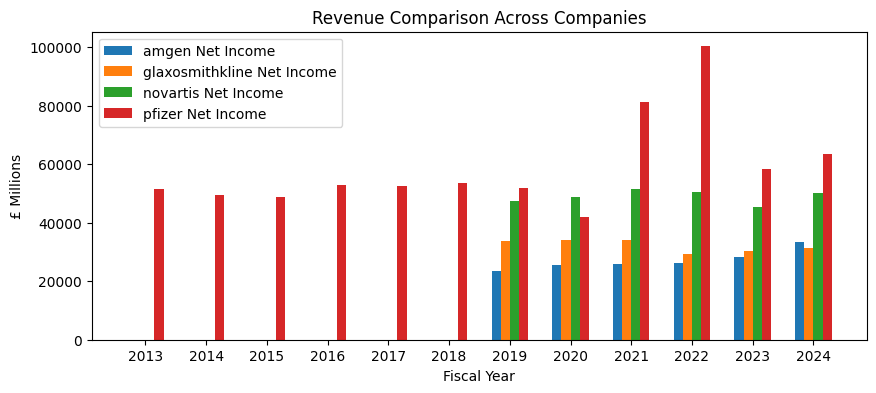

In [59]:
# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(10,4))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["revenue_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue Comparison Across Companies")
plt.legend()
plt.show()

## Analyze total assets

### Subtask:
Visualize and compare the total assets of each company over time to understand their growth and scale.


**Reasoning**:
Filter the dataframe to include only annual reports and group by company and fiscal year to calculate the sum of total assets.



In [60]:
# Filter only annual reports
df_filtered = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    "total_assets_millions"
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years from the grouped dataframe and set up the plotting parameters.



In [61]:
# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

**Reasoning**:
Plot a grouped bar chart to visualize the total assets for each company across the fiscal years.



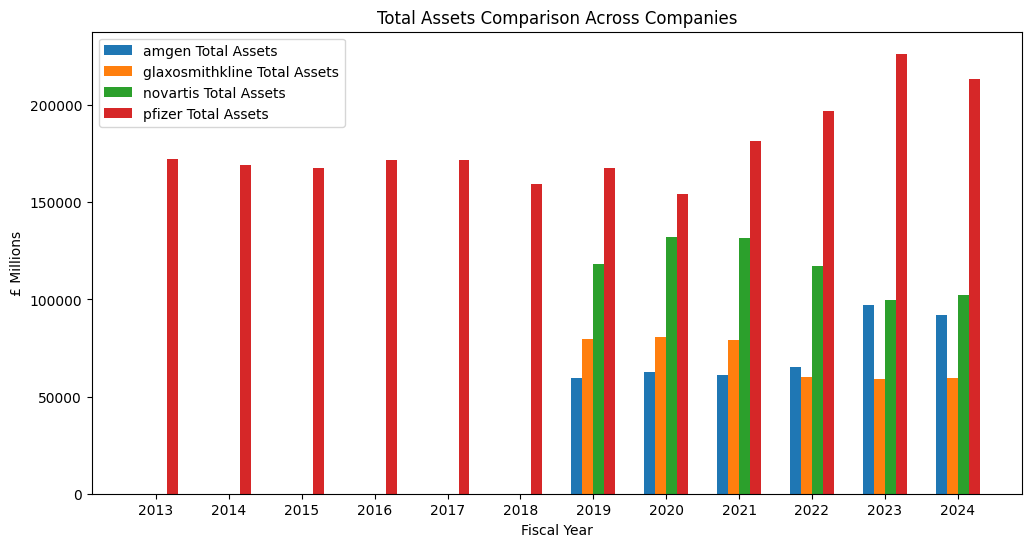

In [62]:
plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    total_assets = [company_data[company_data["fiscal_year"] == y]["total_assets_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, total_assets, width=bar_width, label=f"{company} Total Assets")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Total Assets Comparison Across Companies")
plt.legend()
plt.show()

## Analyze employee count

### Subtask:
Compare the employee counts across companies to understand their workforce size.


**Reasoning**:
Filter the DataFrame to include only annual reports and group by company and fiscal year to get the sum of employee counts.



In [71]:
# Filter only annual reports
df_filtered_employees = df_metrics[df_metrics["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped_employees = df_filtered_employees.groupby(["company_name", "fiscal_year"])[
    "employee_count"
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years, then create a bar chart to visualize the employee count for each company across the fiscal years, setting the labels and title as specified in the instructions.



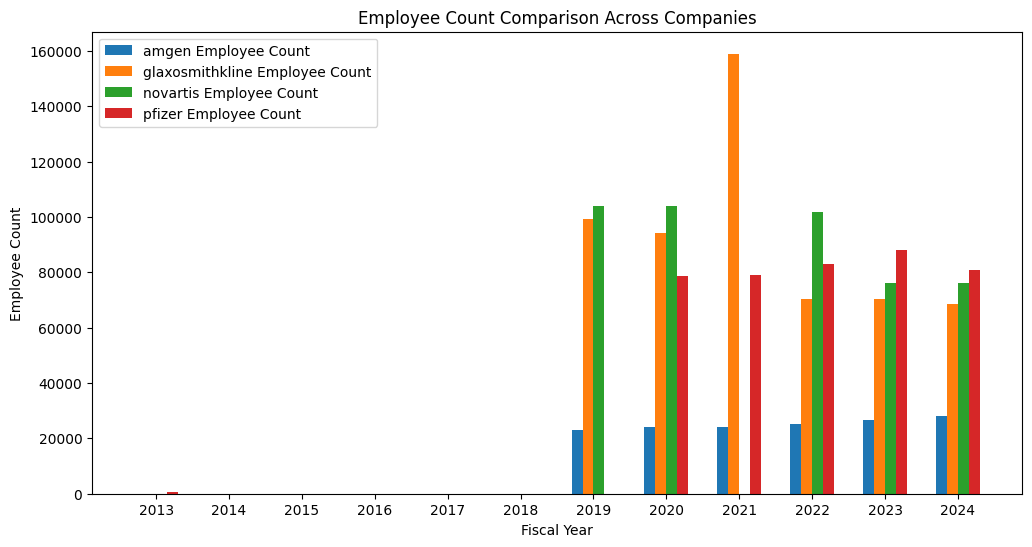

In [72]:
# Get unique values
companies_employees = df_grouped_employees["company_name"].unique().tolist()
years_employees = sorted(df_grouped_employees["fiscal_year"].unique())

# Set bar width
bar_width_employees = 0.15
x_employees = np.arange(len(years_employees))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies_employees):
    company_data = df_grouped_employees[df_grouped_employees["company_name"] == company]
    employee_counts = [company_data[company_data["fiscal_year"] == y]["employee_count"].sum() for y in years_employees]
    plt.bar(x_employees + i*bar_width_employees, employee_counts, width=bar_width_employees, label=f"{company} Employee Count")

plt.xticks(x_employees + bar_width_employees*(len(companies_employees)-1)/2, years_employees)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("Employee Count")
plt.title("Employee Count Comparison Across Companies")
plt.legend()
plt.show()

## Analyze esg metrics (ghg emissions)

### Subtask:
Visualize and compare the Scope 1, Scope 2, Scope 3, and Total GHG emissions for companies that have sustainability reports available.


**Reasoning**:
Filter the DataFrame to include only sustainability reports and then group by company and fiscal year to sum the GHG emissions columns.



In [73]:
# Filter only sustainability reports
df_filtered_esg = df_metrics[df_metrics["report_type"].str.lower() == "sustainability"]

# Group by company and year and sum GHG emission columns
df_grouped_esg = df_filtered_esg.groupby(["company_name", "fiscal_year"])[
    ["scope_1_ghg_emissions", "scope_2_ghg_emissions", "scope_3_ghg_emissions", "total_ghg_emissions"]
].sum().reset_index()

**Reasoning**:
Get the unique company names and sorted fiscal years from the grouped ESG data and then iterate through each company to create a multi-line plot for their GHG emissions over the years.



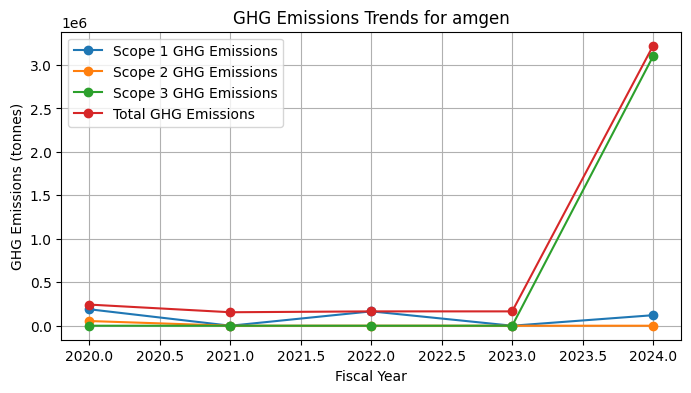

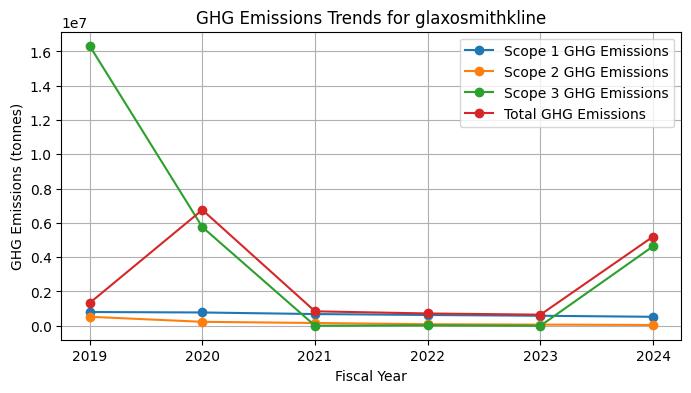

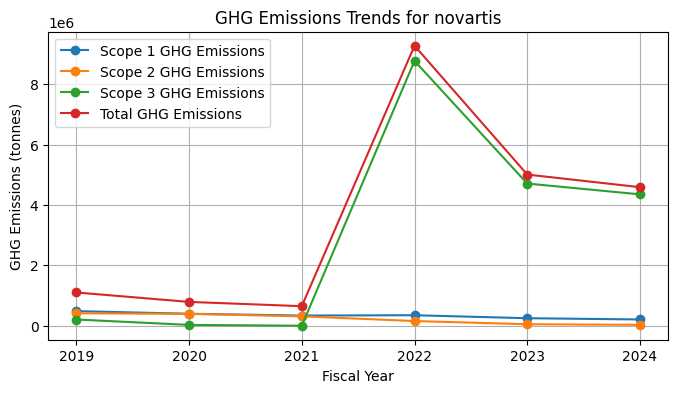

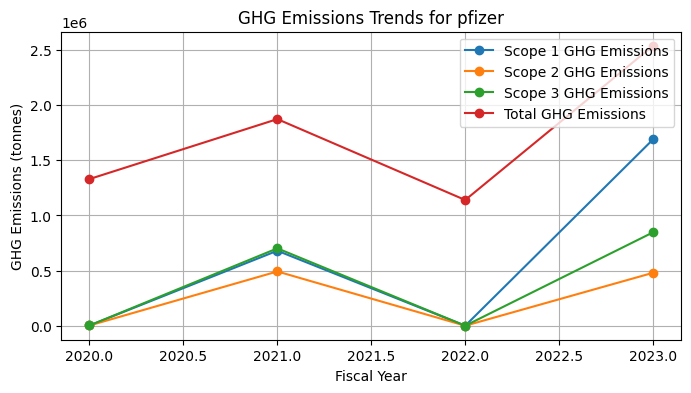

In [74]:
# Get unique values
companies_esg = df_grouped_esg["company_name"].unique().tolist()
years_esg = sorted(df_grouped_esg["fiscal_year"].unique())

# Plot GHG emissions for each company
for company in companies_esg:
    company_data_esg = df_grouped_esg[df_grouped_esg["company_name"] == company]

    plt.figure(figsize=(8, 4))
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_1_ghg_emissions"], marker="o", label="Scope 1 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_2_ghg_emissions"], marker="o", label="Scope 2 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["scope_3_ghg_emissions"], marker="o", label="Scope 3 GHG Emissions")
    plt.plot(company_data_esg["fiscal_year"], company_data_esg["total_ghg_emissions"], marker="o", label="Total GHG Emissions")

    plt.xlabel("Fiscal Year")
    plt.ylabel("GHG Emissions (tonnes)")
    plt.title(f"GHG Emissions Trends for {company}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Forecast Metrics Plots

In [83]:
forecast_metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_FORECAST_TABLE_ID}`
"""
df_forecast_metrics = bpd.read_gbq(forecast_metrics_sql1)

#df_metrics = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
# Create the dataset
dff = df_forecast_metrics.to_pandas()
dff_random = dff.sample(frac=1).reset_index(drop=True)
dff_random.head(10)

,company_name,forecast_timestamp,forecast_value,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,ai_forecast_status
0,novartis,2027-01-01 00:00:00+00:00,25537.679688,0.95,21048.817622,30026.541753,
1,amgen,2025-01-01 00:00:00+00:00,17658.919922,0.95,13946.008842,21371.831002,
2,pfizer,2028-01-01 00:00:00+00:00,69536.007812,0.95,38960.447156,100111.568469,
3,novartis,2025-01-01 00:00:00+00:00,25538.65625,0.95,22368.614042,28708.698458,
4,pfizer,2026-01-01 00:00:00+00:00,68183.890625,0.95,37043.676594,99324.104656,
5,amgen,2026-01-01 00:00:00+00:00,18759.867188,0.95,12997.502732,24522.231643,
6,glaxosmithkline,2025-01-01 00:00:00+00:00,15840.825195,0.95,14545.595366,17136.055025,
7,amgen,2027-01-01 00:00:00+00:00,19563.138672,0.95,12263.302576,26862.974768,
8,pfizer,2027-01-01 00:00:00+00:00,68452.28125,0.95,36697.296954,100207.265546,
9,novartis,2028-01-01 00:00:00+00:00,25993.5,0.95,21111.013429,30875.986571,


/tmp/ipython-input-4157479299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfizer_forecast_df.sort_values(by='forecast_timestamp', inplace=True)


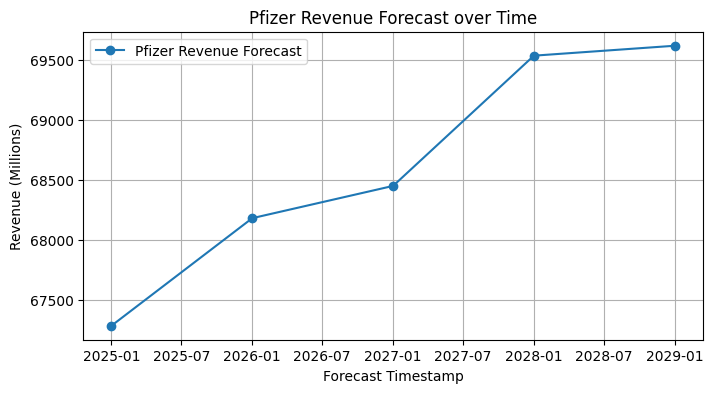

In [76]:
# Filter for Pfizer's forecast data
pfizer_forecast_df = dff[dff['company_name'] == 'pfizer']
pfizer_forecast_df.sort_values(by='forecast_timestamp', inplace=True)
# Plot the forecast
plt.figure(figsize=(8, 4))
plt.plot(pfizer_forecast_df['forecast_timestamp'], pfizer_forecast_df['forecast_value'], marker='o', linestyle='-', label='Pfizer Revenue Forecast')
plt.xlabel("Forecast Timestamp")
plt.ylabel("Revenue (Millions)")
plt.title("Pfizer Revenue Forecast over Time")
plt.legend()
plt.grid(True)
plt.show()

# Visualize forecast graphs using **BigQuery DataFrames**

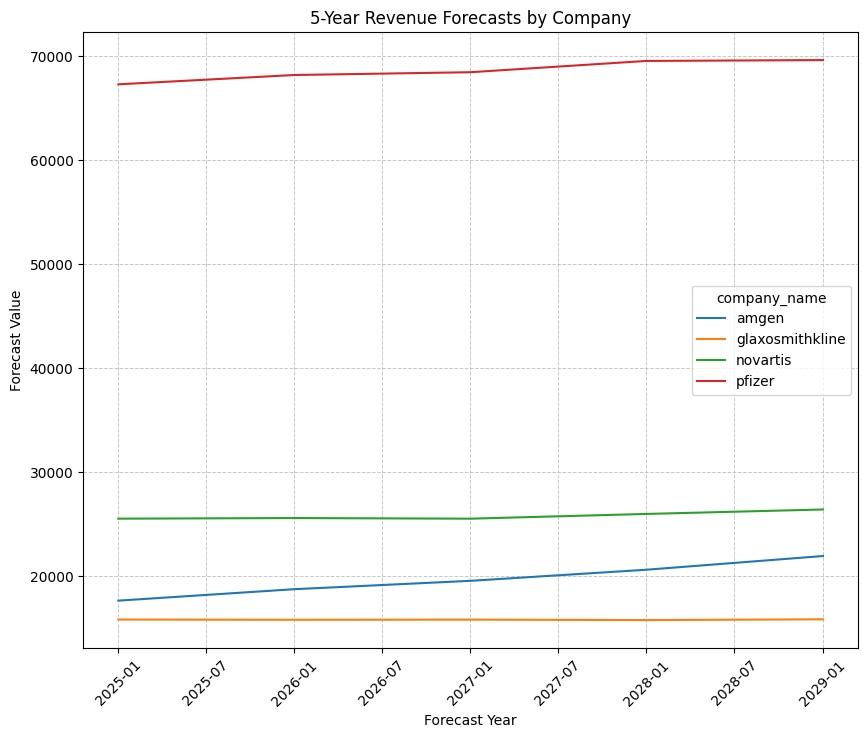

In [97]:
# Read your forecast table
forecast_bf_query = f"""
SELECT *
FROM `{QUALIFIED_FORECAST_TABLE_ID}`
"""
forecast_df = bpd.read_gbq(forecast_bf_query)

# Group by company and timestamp, take mean (if multiple values exist per date)
company_forecasts = (
    forecast_df[["company_name", "forecast_timestamp", "forecast_value"]]
    .groupby(["company_name", "forecast_timestamp"])
    .mean()
    .reset_index()
)

# Pivot for plotting
pivot_df = company_forecasts.pivot(
    index="forecast_timestamp",
    columns="company_name",
    values="forecast_value"
)

# Create larger figure
ax = pivot_df.plot.line(
    title="5-Year Revenue Forecasts by Company",
    figsize=(10, 8)   # wider (10), taller (8)
)

# Add grid lines
ax.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)

# Make labels more readable
plt.xlabel("Forecast Year")
plt.ylabel("Forecast Value")
plt.xticks(rotation=45)

plt.show()

